In [ ]:
# Copyright 2020 IITK EE604A Image Processing. All Rights Reserved.
# 
# Licensed under the MIT License. Use and/or modification of this code outside of EE604 must reference:
#
# © IITK EE604A Image Processing 
# https://github.com/ee604/ee604_assignments
#
# Author: Shashi Kant Gupta, Chiranjeev Prachand and Prof K. S. Venkatesh, Department of Electrical Engineering, IIT Kanpur

# Task 1: Image Enhancement I: Intensity Level

In this task, we will implement following two methods which was taught in class:
1. Gamma modification
2. Histogram equalization

In [ ]:
%%bash
pip install git+https://github.com/ee604/ee604_plugins

  Cloning https://github.com/ee604/ee604_plugins to /tmp/pip-req-build-tozzb19x
  Created wheel for ee604-plugins: filename=ee604_plugins-0.2.2-cp36-none-any.whl size=2313 sha256=7f613b715db71913b27286ebdd0585fd5c670a06635a4c907b1121cc6f49bd47
  Stored in directory: /tmp/pip-ephem-wheel-cache-t2bc5a4a/wheels/34/a8/1d/ae3b7d209ecde89b4800a47ec55a61e7503bb9548bbb975806
Successfully built ee604-plugins


  Running command git clone -q https://github.com/ee604/ee604_plugins /tmp/pip-req-build-tozzb19x


In [ ]:
# Importing required libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt

from ee604_plugins import download_dataset, cv2_imshow
download_dataset(assignment_no=2, task_no=1) # download data for this assignment

Download Complete!


In [ ]:
def gamma_modification(img, gamma=1):
    '''
    Write your program to apply gamma (power law) modification to input image.
    
    Inputs:
    + img - grayscaled image of size N x N
          - values between [0, 255] - 'uint8'
    + gamma - gamma (power law) parameter
    
    Ouputs:
    + out_img - gamma modified grayscaled image of size N x N
              - values between [0, 255] - 'uint8'
    
    Allowed modules:
    + Basic numpy operations
    
    Hint:
    + Not needed.
    
    '''
    
    #############################
    # Start your code from here #
    #############################
    
    out_img = np.copy(img)

    out_img = out_img / 255.0                       # Normalizing the image
    out_img = np.power(out_img, gamma) * 255        # Gamma correction
    out_img = np.round(out_img).astype(np.uint8)
    
    #############################
    # End your code here ########
    #############################    
    
    return out_img

In [ ]:
def histogram_equalization_global(img):
    '''
    Write your program to equalise the intesnity level of the given image using histogram equalization method.
    In this one you have to use the global statistics of the image.
    
    Inputs:
    + img - grayscaled image of size N x N
          - values between [0, 255] - 'uint8'
    
    Ouputs:
    + out_img - histogram equalized grayscaled image of size N x N
              - values between [0, 255] - 'uint8'
    
    Allowed modules:
    + You are allowed to use np.histogram or any relevant numpy module
    + You are not allowed t use cv2.equalizeHist or any other direct implementations
    
    Hint:
    + Not needed.
    
    '''
    
    #############################
    # Start your code from here #
    #############################
    
    out_img = np.copy(img)

    Pdf, _ = np.histogram(img.flatten(), bins=256, range=(0,256))                        # Frequency distribution function
    cumsum = np.cumsum(Pdf)                                                                  # Cumulative sum of frequency dist.
    mapping = np.round((255 * cumsum) / (img.shape[0]*img.shape[1])).astype(np.uint8)        # Storing the mapping values
    
    for i in range(256):
      mask = (img == i)                   # Masking the original value
      out_img[mask] = mapping[i]          # Assigning value corresponding to the transformation mapping
    
    #############################
    # End your code here ########
    #############################    
    
    return out_img

In [ ]:
def histogram_equalization_local(img, kernel_size=15):
    '''
    Write your program to equalise the intesnity level of the given image using histogram equalization method.
    In this one you have to use the global statistics of the image.
    
    Inputs:
    + img - grayscaled image of size N x N
          - values between [0, 255] - 'uint8'
    + kernel_size - size of the kernel window which should be considered for
                  - the local statistics of the image
    
    Ouputs:
    + out_img - locally histogram equalized grayscaled image of size N x N
              - values between [0, 255] - 'uint8'
    
    Allowed modules:
    + You are allowed to use np.histogram or any relevant numpy module
    + You are not allowed t use cv2.equalizeHist or any other direct implementations
    
    Hint:
    + Loop across all the points (i, j) in the input image and take [k, k] size window centered at (i, j). 
      Apply histogram_equalization_global() on the cropped window. Note you need to adjust your code for borders
    + Above mentioned method is not an efficient method and tiling method can be used but that will be
      more complex as you need to interpolate to get the final image.
    + Instead you can use incremental update.
    + Wiki link: https://en.wikipedia.org/wiki/Adaptive_histogram_equalization
    + All three method will award you same marks.
    
    '''
    
    #############################
    # Start your code from here #
    #############################

    ## Applying CLAHE method for local histogram equalization

    def bilinear(img,UL,UR,BL,BR,subx,suby):
      # Function for interpolation
      out = np.zeros(img.shape)
      num = subx*suby
      for i in range(subx):
        inv_i = subx-i
        for j in range(suby):
          inv_j = suby-j
          val = img[i,j].astype(int)
          out[i,j] = np.round((inv_i*(inv_j*UL[val] + j*UR[val]) + i*(inv_j*BL[val] + j*BR[val]))/float(num))
      return out
    
    M, N = img.shape
    padr = kernel_size - int(M % kernel_size)
    padc = kernel_size - int(N % kernel_size)
    thres = 2                                    # threshold for clipping
    center = kernel_size//2

    H, W = M + padr, N + padc
    temp = np.zeros((H, W), dtype=np.uint8)
    offr, offc = padr//2, padc//2                # Padding for tiling 
    temp[offr:offr+M, offc:offc+N] = img
    nrX, nrY = H//kernel_size, W//kernel_size
    out_img = np.zeros((H,W))

    # Make histogram
    hist = np.zeros((nrX, nrY, 256))
    for i in range(nrX):
      for j in range(nrY):
        img_slice = temp[i*kernel_size:(i+1)*kernel_size, j*kernel_size:(j+1)*kernel_size]
        hist[i,j], _ = np.histogram(img_slice.flatten(), 256, (0,256))

    # Clipping the histogram
    for i in range(nrX):
      for j in range(nrY):
        err=0
        for nr in range(256):
          excess = (hist[i,j,nr]-thres)
          if excess>0:
            err = err + excess
        
        incr = err/256
        upper = thres - incr
        for nr in range(256):
          if hist[i,j,nr] > thres:
            hist[i,j,nr] = thres
          else:
            if hist[i,j,nr]>upper:
              err += upper - hist[i,j,nr]
              hist[i,j,nr] = thres
            else:
              err -= incr
              hist[i,j,nr] += incr

        if err>0:
          stepSz = max(1,np.floor(1+err/256))
          for nr in range(256):
            err -= stepSz
            hist[i,j,nr] += stepSz
            if err<1:
              break

    # Mapping histogram
    map = np.zeros((nrX, nrY, 256))
    for i in range(nrX):
      for j in range(nrY):
        cumsum = np.cumsum(hist[i,j])
        map[i,j] = np.round((255 * cumsum) / (kernel_size*kernel_size))

    # Interpolation
    xi = 0
    for i in range(nrX+1):
      if i==0:
        subx = center
        xu = 0
        xb = 0
      elif i==nrX:
        subx = center
        xu = nrX-1
        xb = nrX-1
      else:
        subx = kernel_size
        xu = i-1
        xb = i

      yi = 0
      for j in range(nrY+1):
        if j==0:
          suby = center
          yl = 0
          yr = 0
        elif j==nrY:
          suby = center
          yl = nrY-1
          yr = nrY-1
        else:
          suby = kernel_size
          yl = j-1
          yr = j
        
        UL = map[xu,yl,:]
        UR = map[xu,yr,:]
        BL = map[xb,yl,:]
        BR = map[xb,yr,:]
        img_slice = temp[xi:xi+subx,yi:yi+suby]
        out_img[xi:xi+subx,yi:yi+suby] = bilinear(img_slice,UL,UR,BL,BR,subx,suby)
        yi = yi+suby
      xi = xi+subx

    out_img = out_img[offr:offr+M, offc:offc+N].astype(np.uint8)
    
    #############################
    # End your code here ########
    #############################    
    
    return out_img

### Test

---

In [ ]:
# Do not change codes inside this cell
# Add your observations in next to next cell
# Your observation should compare the different methods for different images

weeki_img = cv2.imread('data/gamma_modified_Weeki_Wachee_spring.jpg', 0)
hawkes_img = cv2.imread('data/Unequalized_Hawkes_Bay_NZ.jpg', 0)
tsukabi_l = cv2.imread('data/tsukuba_l.png', 0)

def plot_frame(gridx, gridy, subplot_id, img, name):
    plt.subplot(gridx, gridy, 1 + int(subplot_id))
    plt.imshow(np.uint8(img), cmap="gray", vmin=0, vmax=255)
    plt.axis("off")
    plt.title(name)


-------------------------
#   Weeki Wachee
-------------------------


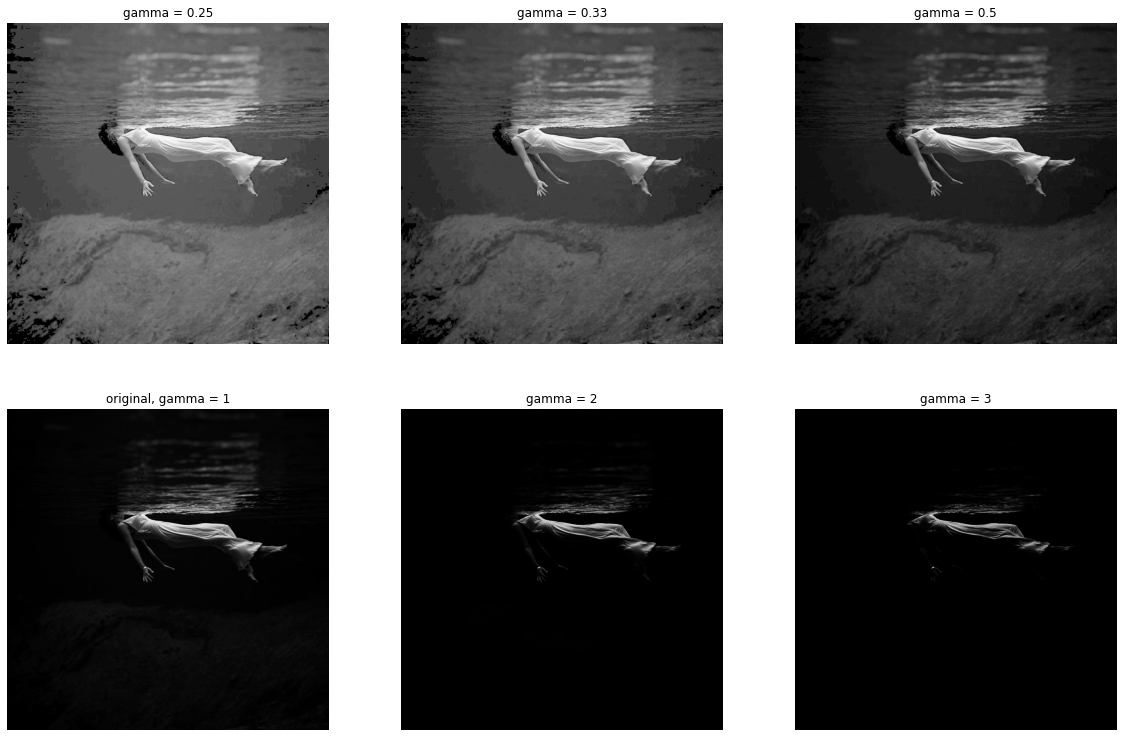


-------------------------
#   Hawkes Bay (NZ)
-------------------------


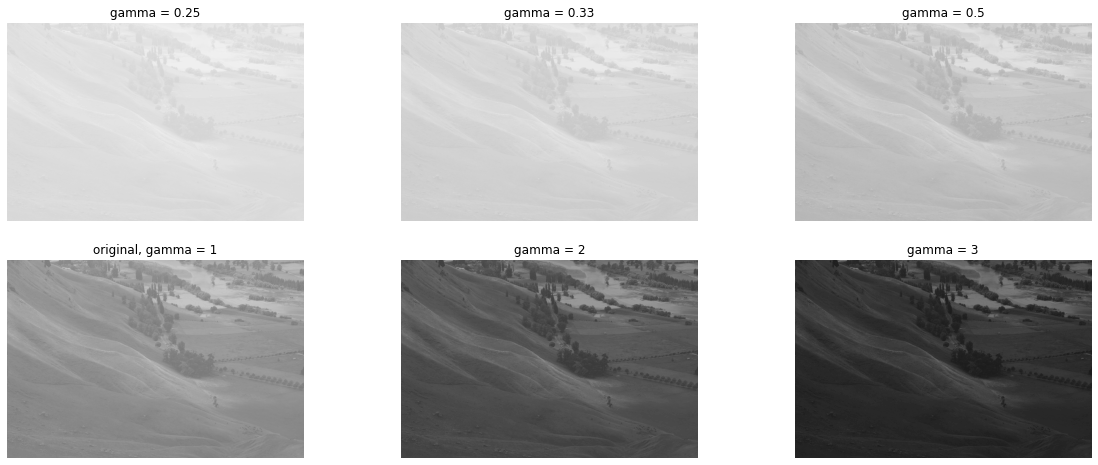

In [ ]:
# Do not change codes inside this cell
# Add your observations in next cell

print("\n-------------------------")
print("#   Weeki Wachee")
print("-------------------------")
plt.figure(figsize=(20, 13))
count = 0
for i in [1/4, 1/3, 1/2, 1, 2, 3]:
    tmp_img = gamma_modification(np.copy(weeki_img), gamma=i)
    if i == 1:
        title = "original, gamma = 1"
    else:
        title = "gamma = " + str(round(i, 2))
        
    plot_frame(2, 3, count, tmp_img, title)
    count += 1
plt.show()

print("\n-------------------------")
print("#   Hawkes Bay (NZ)")
print("-------------------------")
plt.figure(figsize=(20, 8))
count = 0
for i in [1/4, 1/3, 1/2, 1, 2, 3]:
    tmp_img = gamma_modification(np.copy(hawkes_img), gamma=i)
    if i == 1:
        title = "original, gamma = 1"
    else:
        title = "gamma = " + str(round(i, 2))
        
    plot_frame(2, 3, count, tmp_img, title)
    count += 1
plt.show()


-------------------------
#    Tsukabi
-------------------------


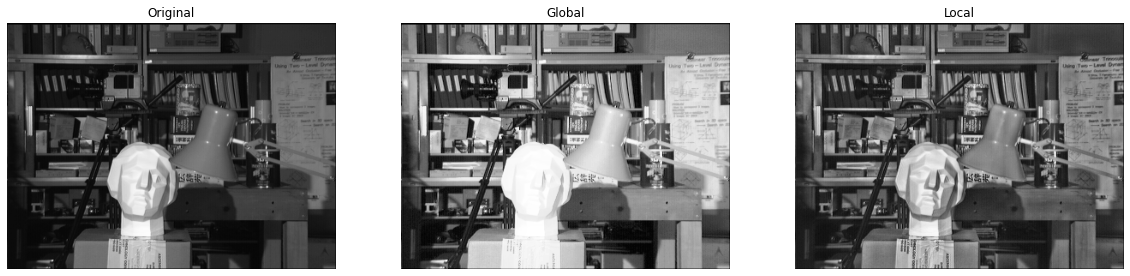


-------------------------
#    Hawkes Bay (NZ)
-------------------------


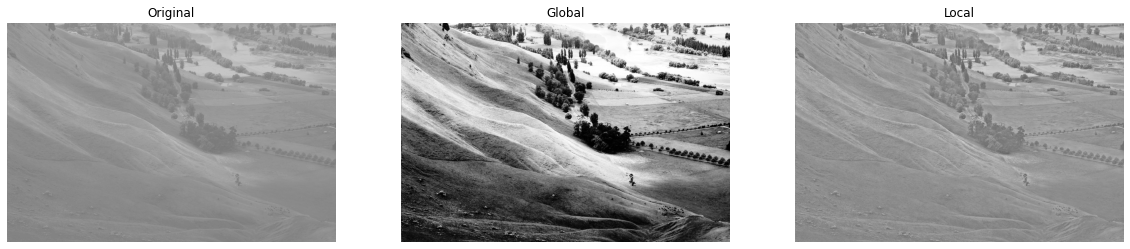


-------------------------
#    Weeki Wachee
-------------------------


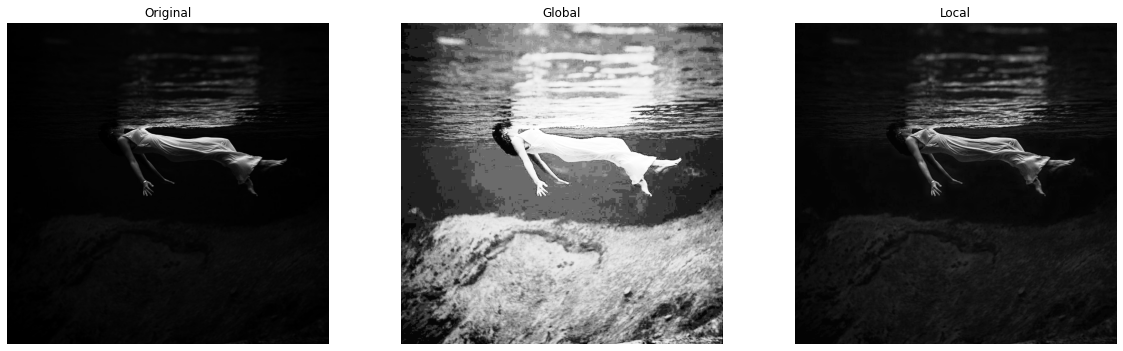

In [ ]:
img_arr = [tsukabi_l, hawkes_img, weeki_img]
img_caption = ["Tsukabi", "Hawkes Bay (NZ)", "Weeki Wachee"]
for i in range(3):
    print("\n-------------------------")
    print("#   ", img_caption[i])
    print("-------------------------")
    
    plt.figure(figsize=(20, 13))
    plot_frame(2, 3, 0, img_arr[i], "Original")
    
    tmp_img = histogram_equalization_global(np.copy(img_arr[i]))
    plot_frame(2, 3, 1, tmp_img, "Global")
    
    tmp_img = histogram_equalization_local(np.copy(img_arr[i]))
    plot_frame(2, 3, 2, tmp_img, "Local")

    plt.show()

In [ ]:
your_observation = """
From the following intensity enhancement techniques:

Gamma correction:
1. With decrease in the value of gamma more and more stretching of intensity level takes place towards higher levels and vice-versa.
2. A very simple and efficient method of enhacinng darker images with gamma < 1 and brighter images with gamma > 1.

Global histogram equalization:
1. A simple method for the intensity enhacement of images but creates problem of higher contrast level in the images leading to intense brightening of
bright part regions.

Local histogram equalization:
1. I applied the CLAHE method, which provides clipping in the histogram with higher intensity contrast value and redistributing them uniformly to
all the parts of a local region.
2. Bilinear interpolation method provides smooth transition from one window to another gaining better enhacement without intense brightness,
preerving the grey values and solving the problem with the global histogram equalization method.
"""

print(your_observation)


From the following intensity enhancement techniques:

Gamma correction:
1. With decrease in the value of gamma more and more stretching of intensity level takes place towards higher levels and vice-versa.
2. A very simple and efficient method of enhacinng darker images with gamma < 1 and brighter images with gamma > 1.

Global histogram equalization:
1. A simple method for the intensity enhacement of images but creates problem of higher contrast level in the images leading to intense brightening of
bright part regions.

Local histogram equalization:
1. I applied the CLAHE method, which provides clipping in the histogram with higher intensity contrast value and redistributing them uniformly to
all the parts of a local region.
2. Bilinear interpolation method provides smooth transition from one window to another gaining better enhacement without intense brightness,
preerving the grey values and solving the problem with the global histogram equalization method.



In [ ]:
# Submission >>>>>>>>>>>>>>>>>>>>>
# Do not change codes inside this cell.

img_arr = [tsukabi_l, hawkes_img, weeki_img]
gen_imgs = []

for i in range(3):
    for gamma in [1/4, 1/3, 1/2, 1, 2, 3]:
        tmp_img = gamma_modification(np.copy(img_arr[i]), gamma=gamma)
        gen_imgs.append(tmp_img)
        
    tmp_img = histogram_equalization_global(np.copy(img_arr[i]))
    gen_imgs.append(tmp_img)

    tmp_img = histogram_equalization_local(np.copy(img_arr[i]))
    gen_imgs.append(tmp_img)

task1_submission = np.array(gen_imgs)